<a href="https://colab.research.google.com/github/grimloch-ai/DataAnalyticsPython/blob/CO2_Emissions_Assignment/CO2_Emissions_v1_0_RS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Starting CO2 Emissions Analysis...

Analyzing predictors of CO2 output per capita...


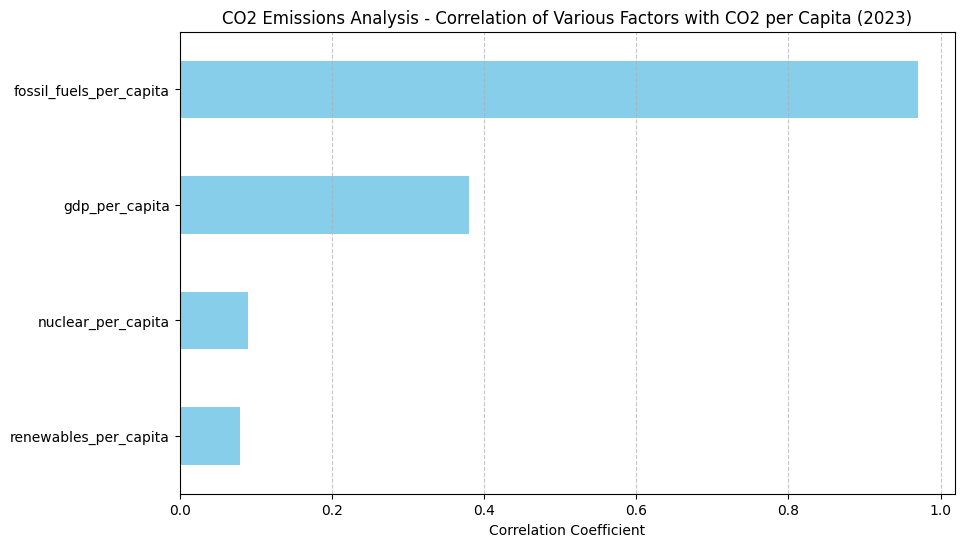

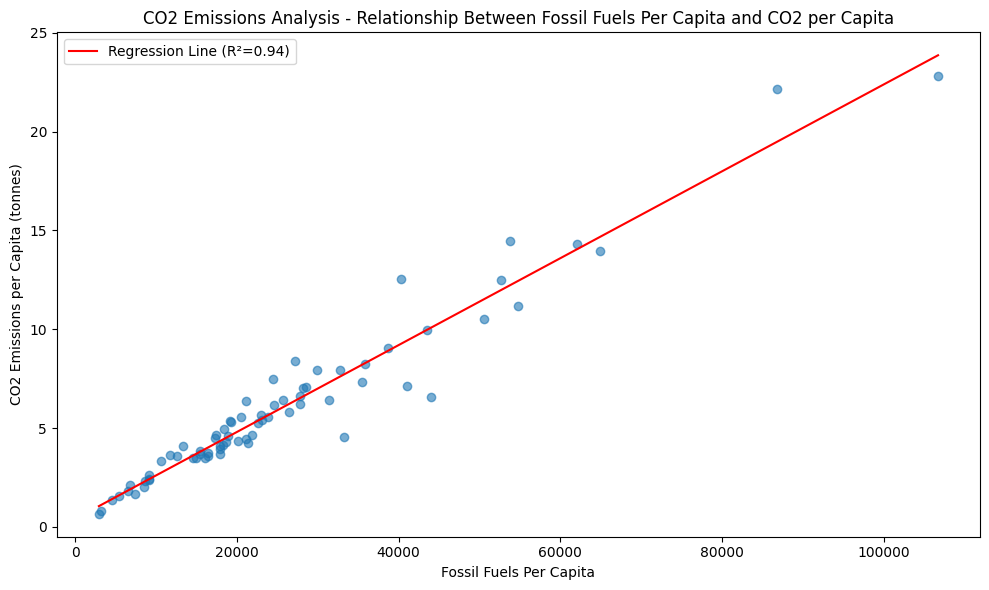

The strongest predictor of CO2 per capita in 2023 is: fossil_fuels_per_capita
Correlation coefficients:
fossil_fuels_per_capita    0.97
gdp_per_capita             0.38
nuclear_per_capita         0.09
renewables_per_capita      0.08
Name: co2_per_capita, dtype: float64

Analyzing countries with biggest reductions in CO2 emissions...


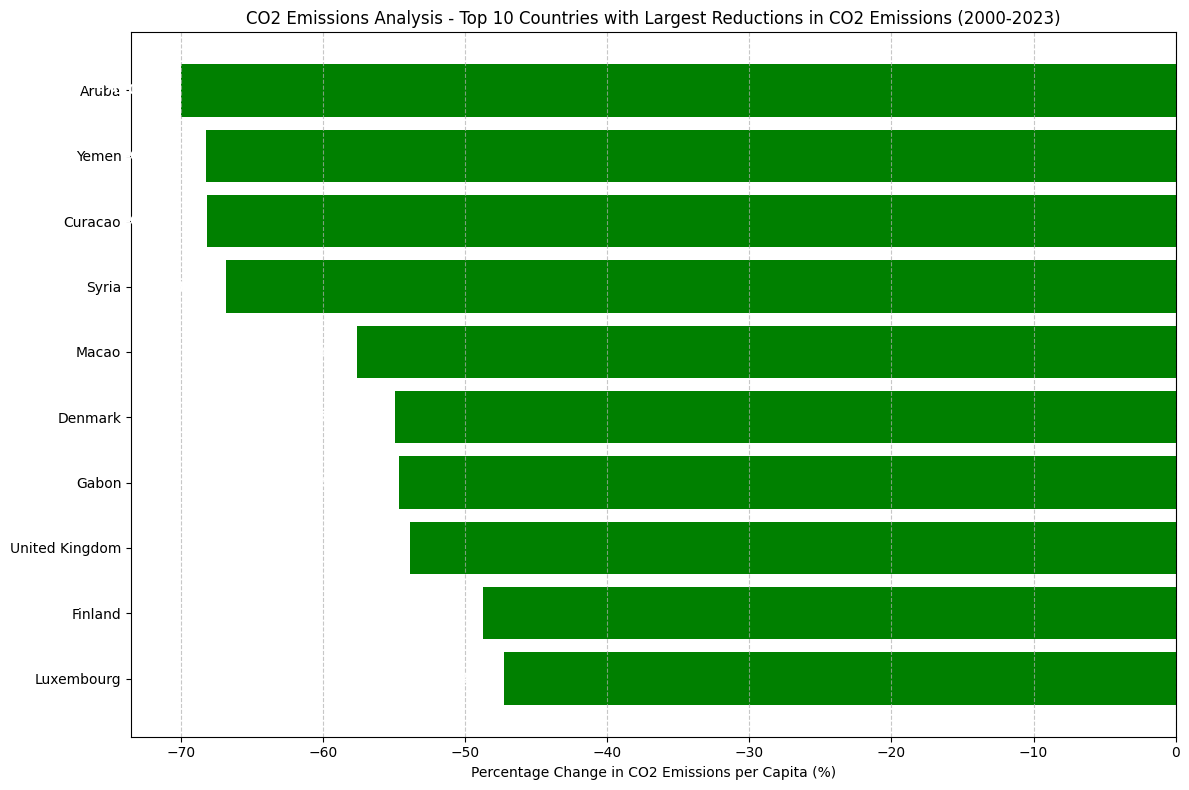

Top 10 countries with largest reductions (2000-2023):
        entity  percent_change
         Aruba          -70.01
         Yemen          -68.21
       Curacao          -68.18
         Syria          -66.80
         Macao          -57.60
       Denmark          -54.92
         Gabon          -54.67
United Kingdom          -53.89
       Finland          -48.75
    Luxembourg          -47.30

Predicting future prices of non-fossil fuel energy technologies...


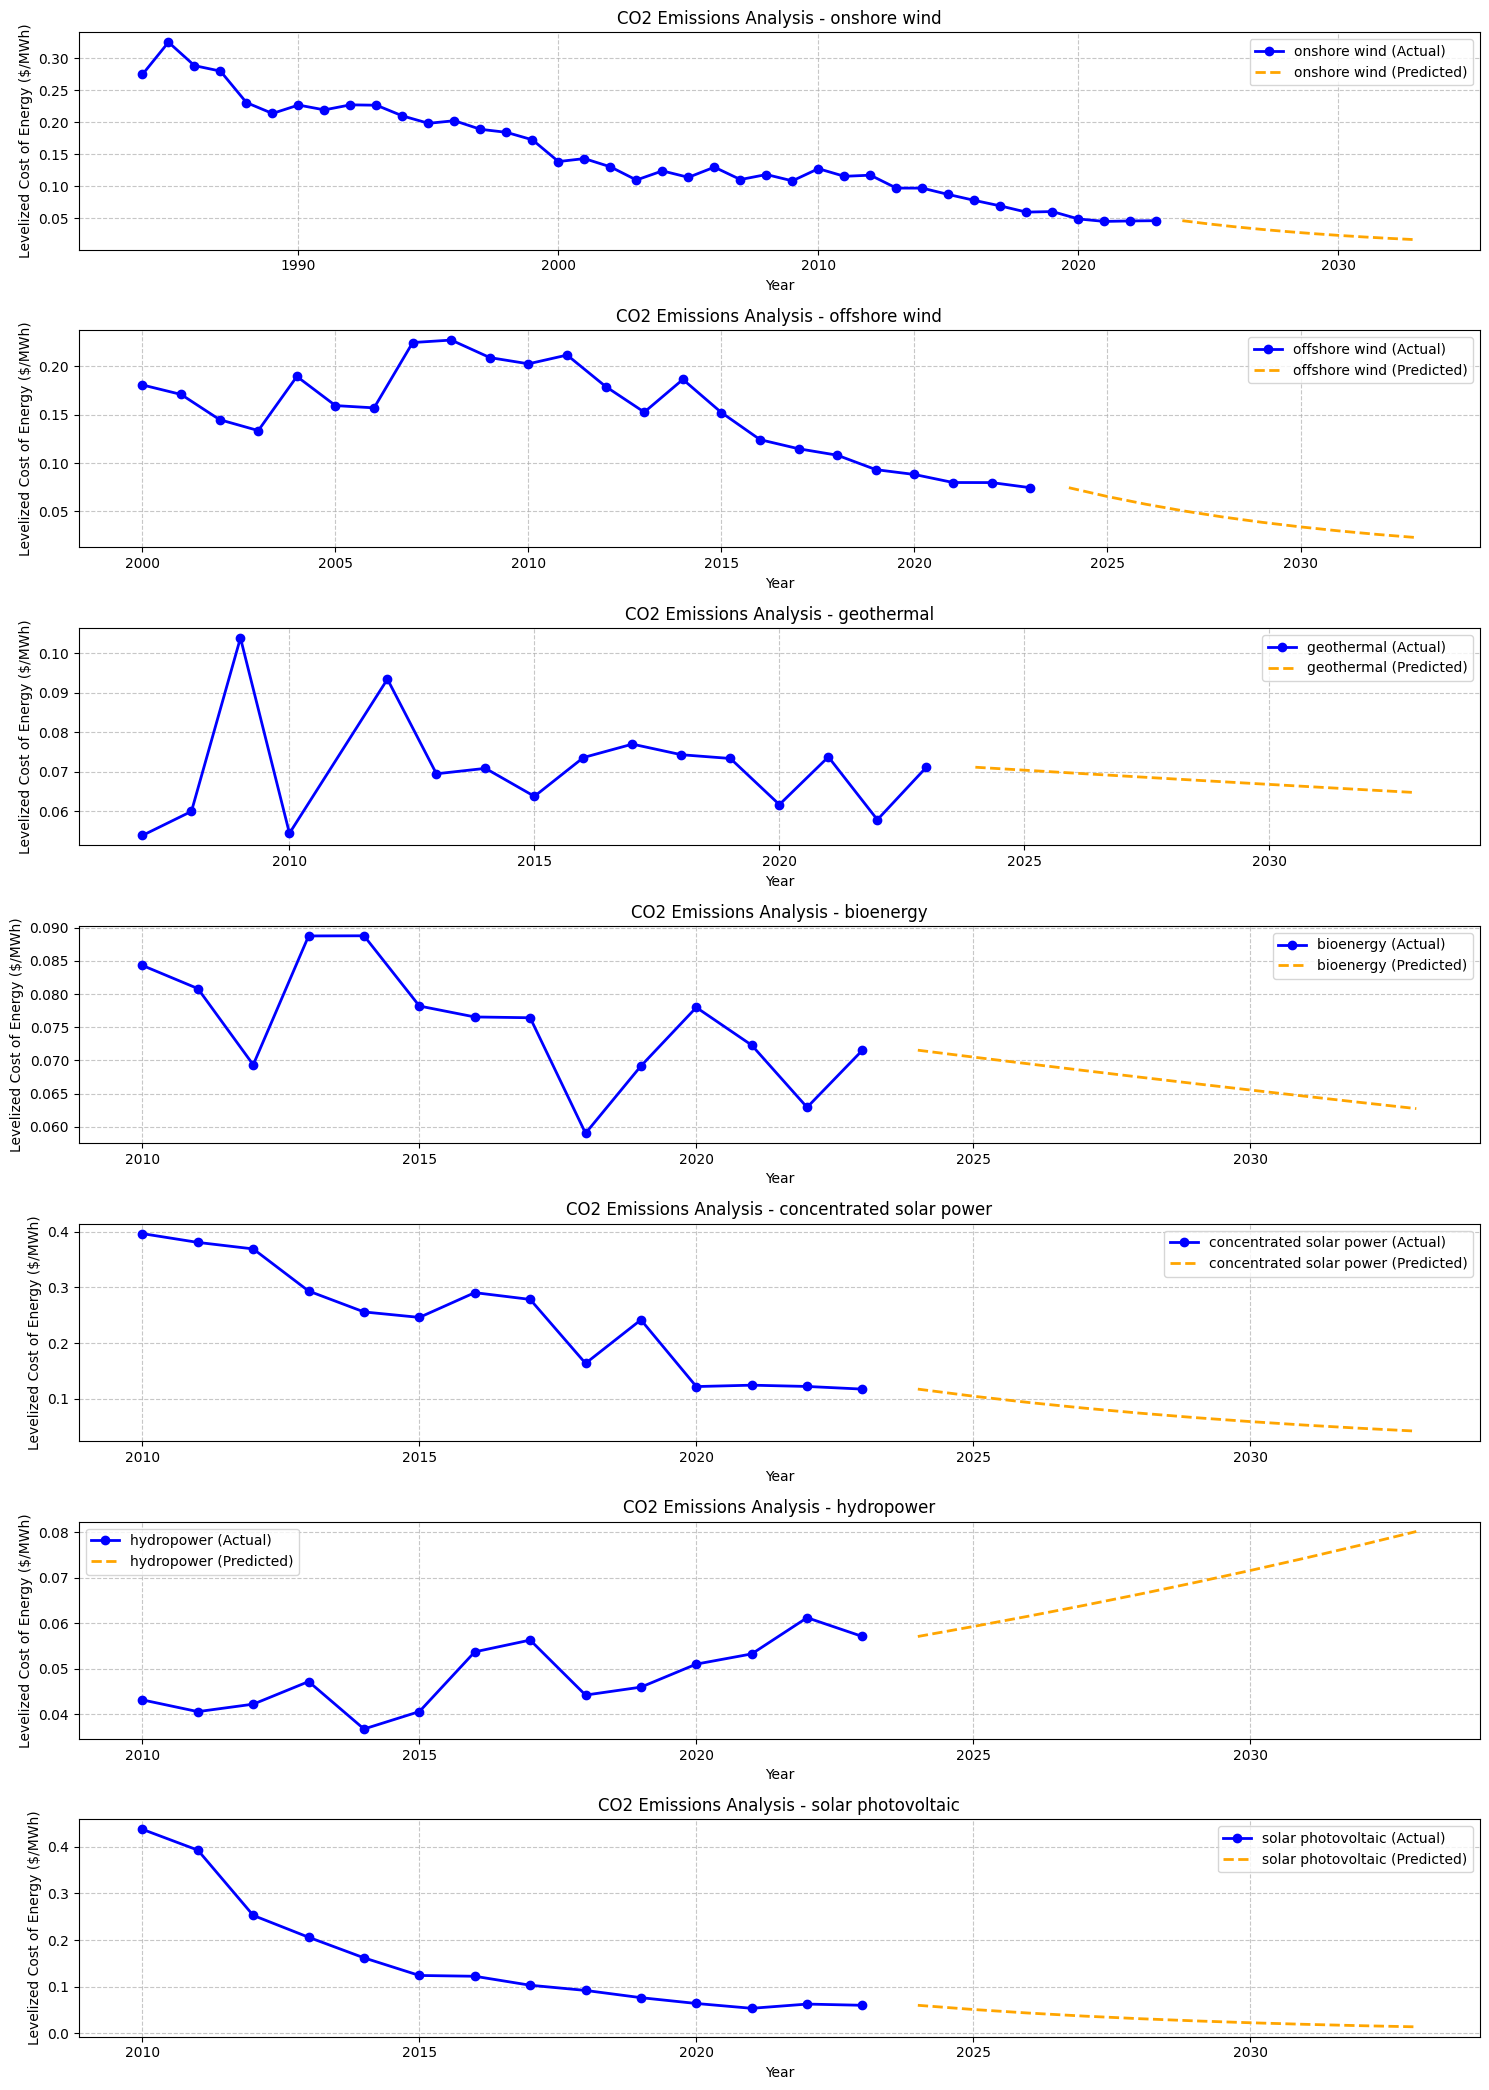

The non-fossil fuel energy technology projected to have the best price in 2033 is: solar photovoltaic
The non-fossil fuel energy technology projected to have the best price in the future is: solar photovoltaic

Analysis complete. Visualizations have been generated.


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import requests

# Configuration
CO2_PER_CAPITA_URL = "https://raw.githubusercontent.com/grimloch-ai/DataAnalyticsPython/refs/heads/CO2_Emissions_Assignment/per-capita-co-emissions.csv"
GDP_PER_CAPITA_URL = "https://raw.githubusercontent.com/grimloch-ai/DataAnalyticsPython/refs/heads/CO2_Emissions_Assignment/gdp-per-capita-worldbank.csv"
ENERGY_MIX_URL = "https://raw.githubusercontent.com/grimloch-ai/DataAnalyticsPython/refs/heads/CO2_Emissions_Assignment/per-capita-energy-source-stacked.csv"
LCOE_DATA_URL = "https://raw.githubusercontent.com/grimloch-ai/DataAnalyticsPython/refs/heads/CO2_Emissions_Assignment/levelized-cost-of-energy.csv"

# Helper Functions
def standardize_column_names(df):
    """Convert all column names to lowercase for consistency."""
    df.columns = [col.lower() for col in df.columns]
    return df

def load_data(url):
    """Load data from a given URL and standardize column names with error handling."""
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise an exception for bad status codes
        df = pd.read_csv(url)
        return standardize_column_names(df)
    except requests.exceptions.RequestException as e:
        print(f"Error loading data from {url}: {e}")
        return None
    except pd.errors.EmptyDataError:
        print(f"Error: No data found at {url}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred while loading data from {url}: {e}")
        return None

# Data Loading Functions
def load_co2_per_capita():
    """Load CO2 per capita data from Our World in Data."""
    return load_data(CO2_PER_CAPITA_URL)

def load_gdp_per_capita():
    """Load GDP per capita data from Our World in Data."""
    return load_data(GDP_PER_CAPITA_URL)

def load_energy_mix():
    """Load energy mix data from Our World in Data."""
    return load_data(ENERGY_MIX_URL)

def load_lcoe_data():
    """Load levelized cost of energy data from Our World in Data."""
    return load_data(LCOE_DATA_URL)

# Reusable Visualization Functions
def create_correlation_bar_chart(correlation_data, title, figsize=(10, 6)):
    """Create a horizontal bar chart showing correlations."""
    plt.figure(figsize=figsize)
    correlation_data.round(2).sort_values(ascending=True).plot(kind='barh', color='skyblue')
    plt.xlabel('Correlation Coefficient')
    plt.title(title)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    return plt.gcf()

def create_regression_scatter_plot(X, y, x_label, y_label, title, figsize=(10, 6)):
    """Create a scatter plot with a regression line."""
    model = LinearRegression().fit(X, y)
    plt.figure(figsize=figsize)
    plt.scatter(X, y, alpha=0.6)
    x_sorted = np.array(sorted(X.flatten())).reshape(-1, 1)
    predicted_y = model.predict(x_sorted)
    plt.plot(x_sorted.flatten(), predicted_y, color='red',
             label=f'Regression Line (R²={r2_score(y, model.predict(X)):.2f})')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    return plt.gcf(), model

def create_horizontal_bar_chart(categories, values, title, x_label, figsize=(12, 8), color='green'):
    """Create a horizontal bar chart with value labels."""
    plt.figure(figsize=figsize)
    plt.gca().invert_yaxis()  # Put highest values at the top
    bars = plt.barh(categories, values, color=color)
    plt.xlabel(x_label)
    plt.title(title)
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    # Add value labels
    for bar in bars:
        width = bar.get_width()
        plt.text(width - 2, bar.get_y() + bar.get_height()/2,
                f'{width:.1f}%', ha='right', va='center', color='white', fontweight='bold')

    plt.tight_layout()
    return plt.gcf()

def create_time_series_panel_plot(data_dict, title_prefix="", figsize=(15, None)):
    """Create a multi-panel time series plot for renewable energy price data."""
    num_technologies = len(data_dict)
    fig_height = num_technologies * 3 if figsize[1] is None else figsize[1]

    fig = plt.figure(figsize=(figsize[0], fig_height))

    for i, (tech, tech_data) in enumerate(data_dict.items()):
        ax = fig.add_subplot(num_technologies, 1, i+1)

        # Historical data (solid line)
        historical = tech_data[~tech_data['predicted']]
        ax.plot(historical['year'], historical['price'], 'o-', linewidth=2,
                label=f'{tech} (Actual)', color='blue')

        # Predicted data (dashed line)
        predicted = tech_data[tech_data['predicted']]
        if not predicted.empty:
            ax.plot(predicted['year'], predicted['price'], '--', linewidth=2,
                    label=f'{tech} (Predicted)', color='orange')

        ax.set_xlabel('Year')
        ax.set_ylabel('Levelized Cost of Energy ($/MWh)')
        ax.set_title(f'{title_prefix}{tech}')
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.legend(loc='best')

    plt.tight_layout()
    return fig

# Analysis Functions
def analyze_co2_predictors(year=2023, title_prefix=""):
    """
    Analyze correlations between CO2 per capita and potential predictors for a given year.
    Returns the strongest predictor, correlation analysis, and the merged dataframe.
    """
    co2_data = load_co2_per_capita()
    gdp_data = load_gdp_per_capita()
    energy_data = load_energy_mix()

    if co2_data is None or gdp_data is None or energy_data is None:
        print("Error: Could not load all necessary data for CO2 predictor analysis.")
        return None, None, None

    # Filter data for the specified year
    co2_year = co2_data[co2_data['year'] == year].copy()
    gdp_year = gdp_data[gdp_data['year'] == year].copy()
    energy_year = energy_data[energy_data['year'] == year].copy()

    # Merge datasets
    merged_df = pd.merge(co2_year, gdp_year, on='entity', suffixes=('', '_gdp'), how='inner')
    merged_df = pd.merge(merged_df, energy_year, on='entity', suffixes=('', '_energy'), how='inner')

    # Rename columns for analysis
    column_mapping = {
        'annual co₂ emissions (per capita)': 'co2_per_capita',
        'gdp per capita, ppp (constant 2021 international $)': 'gdp_per_capita',
        'fossil fuels per capita (kwh)': 'fossil_fuels_per_capita',
        'nuclear per capita (kwh - equivalent)': 'nuclear_per_capita',
        'renewables per capita (kwh - equivalent)': 'renewables_per_capita'
    }

    for old_name, new_name in column_mapping.items():
        if old_name in merged_df.columns:
            merged_df[new_name] = merged_df[old_name]

    # Select predictors and handle missing values
    predictors = ['gdp_per_capita', 'fossil_fuels_per_capita', 'nuclear_per_capita', 'renewables_per_capita']
    columns_for_analysis = ['co2_per_capita'] + predictors
    merged_df_clean = merged_df.dropna(subset=columns_for_analysis).copy()

    # Correlation analysis
    correlation_data = merged_df_clean[columns_for_analysis].corr()['co2_per_capita'].drop('co2_per_capita')

    # Visualization: Correlation bar chart using reusable function
    create_correlation_bar_chart(
        correlation_data,
        f'{title_prefix}Correlation of Various Factors with CO2 per Capita ({year})'
    )

    # Strongest predictor scatter plot with regression line using reusable function
    strongest_predictor = correlation_data.abs().idxmax()
    X = merged_df_clean[strongest_predictor].values.reshape(-1, 1)
    y = merged_df_clean['co2_per_capita'].values

    create_regression_scatter_plot(
        X, y,
        strongest_predictor.replace('_', ' ').title(),
        'CO2 Emissions per Capita (tonnes)',
        f'{title_prefix}Relationship Between {strongest_predictor.replace("_", " ").title()} and CO2 per Capita'
    )

    plt.show()
    return strongest_predictor, correlation_data, merged_df_clean

def analyze_co2_reductions(start_year=2000, end_year=2023, title_prefix=""):
    """
    Calculate which countries have made the biggest strides in reducing CO2 emissions
    Accounts for population changes.
    """
    # Load CO2 emissions data
    co2_data = load_co2_per_capita()
    if co2_data is None:
        print("Error: Could not load CO2 per capita data for reduction analysis.")
        return None

    # Filter for start and end years
    start_data = co2_data[co2_data['year'] == start_year].copy()
    end_data = co2_data[co2_data['year'] == end_year].copy()

    # Rename CO2 column for easier reference
    start_data['co2_per_capita'] = start_data['annual co₂ emissions (per capita)']
    end_data['co2_per_capita'] = end_data['annual co₂ emissions (per capita)']

    # Remove rows with missing CO2 values
    start_data = start_data.dropna(subset=['co2_per_capita'])
    end_data = end_data.dropna(subset=['co2_per_capita'])

    # Merge to get only countries with data in both years
    reduction_df = pd.merge(
        start_data[['entity', 'co2_per_capita']],
        end_data[['entity', 'co2_per_capita']],
        on='entity',
        suffixes=('_start', '_end'),
        how='inner'
    )

    # Calculate absolute and percentage changes
    reduction_df['absolute_change'] = reduction_df['co2_per_capita_end'] - reduction_df['co2_per_capita_start']
    reduction_df['percent_change'] = (reduction_df['absolute_change'] / reduction_df['co2_per_capita_start']) * 100

    # Get top 10 countries with largest reduction (negative percent change)
    top_reducers = (reduction_df.sort_values('percent_change').head(10)).round(2)

    # Create visualization of top reducers using reusable function
    create_horizontal_bar_chart(
        top_reducers['entity'],
        top_reducers['percent_change'],
        f'{title_prefix}Top 10 Countries with Largest Reductions in CO2 Emissions ({start_year}-{end_year})',
        'Percentage Change in CO2 Emissions per Capita (%)'
    )

    plt.show()
    return top_reducers


def prepare_lcoe_historical_data(lcoe_data):
    """Clean and prepare historical LCOE data."""
    if lcoe_data is None:
        return None

    # Extract relevant columns for energy sources
    energy_sources = [
        'bioenergy levelized cost of energy',
        'geothermal levelized cost of energy',
        'offshore wind levelized cost of energy',
        'solar photovoltaic levelized cost of energy',
        'concentrated solar power levelized cost of energy',
        'hydropower levelized cost of energy',
        'onshore wind levelized cost of energy'
    ]

    # Reshape data into a long format (year, technology, price)
    reshaped_data = []
    for source in energy_sources:
        if source in lcoe_data.columns:
            for _, row in lcoe_data.iterrows():
                if pd.notna(row[source]):  # Skip missing values
                    reshaped_data.append({
                        'year': row['year'],
                        'technology': source.replace(' levelized cost of energy', ''),
                        'price': row[source]
                    })

    # Convert to DataFrame
    historical_df = pd.DataFrame(reshaped_data)

    # Clean data
    historical_df = historical_df.dropna(subset=['year', 'price'])
    historical_df['year'] = pd.to_numeric(historical_df['year'], errors='coerce')
    historical_df = historical_df.dropna(subset=['year'])

    # Aggregate multiple data points per year using median
    historical_df = historical_df.groupby(['year', 'technology'], as_index=False).median()

    # Add predicted column
    historical_df['predicted'] = False

    return historical_df

def apply_tech_learning_curve(prices, tech, years_since_start):
    """Apply technology-specific learning rates to adjust future price predictions."""
    if tech.lower() in ['solar photovoltaic', 'onshore wind', 'offshore wind']:
        # Apply specific learning rates by technology
        if tech.lower() == 'solar photovoltaic':
            learning_rate = 0.25  # 25% reduction per doubling for solar PV
        elif tech.lower() == 'offshore wind':
            learning_rate = 0.20  # 20% reduction per doubling for offshore wind
        else:  # onshore wind
            learning_rate = 0.15  # 15% reduction per doubling for onshore wind

        # Estimate deployment growth
        annual_growth_rate = 0.15  # 15% annual capacity growth
        cumulative_growth = np.power(1 + annual_growth_rate, years_since_start)

        # Apply learning curve effect (higher growth = stronger price reduction)
        learning_effect = np.power(cumulative_growth, -np.log2(1-learning_rate))
        prices = prices / learning_effect

    return prices

def predict_technology_prices(tech_data, future_years):
    """Create price predictions for a single technology."""
    if len(tech_data) < 2:  # Skip if insufficient data
        return []

    # Use only recent data to capture recent trends
    recent_cutoff_year = tech_data['year'].max() - 10
    recent_data = tech_data[tech_data['year'] > recent_cutoff_year]

    # Only use recent data if we have enough points
    if len(recent_data) >= 3:  # Need at least 3 points for meaningful regression
        tech_data = recent_data

    # Add weighted regression where newer points have more influence
    X = tech_data['year'].values.reshape(-1, 1)
    y = np.log(tech_data['price'].values)

    # Create weights that increase for more recent years
    years_from_latest = tech_data['year'].max() - tech_data['year']
    weights = np.exp(-0.2 * years_from_latest)  # Exponential weighting

    # Fit weighted model
    model = LinearRegression().fit(X, y, sample_weight=weights)

    # Predict future values
    X_future = future_years.reshape(-1, 1)
    raw_predictions = model.predict(X_future)

    # Ensure smooth transition from historical to predicted data
    last_year = tech_data['year'].max()
    last_price = tech_data[tech_data['year'] == last_year]['price'].values[0]
    first_predicted_value = np.exp(model.predict(np.array([[future_years[0]]]))[0])

    # Calculate adjustment factor to ensure continuity
    adjustment_factor = last_price / first_predicted_value

    # Apply adjustment to all predictions
    y_future = np.exp(raw_predictions) * adjustment_factor

    # Apply technology-specific learning curves
    tech_name = tech_data['technology'].iloc[0]
    years_since_start = np.arange(len(future_years))
    y_future = apply_tech_learning_curve(y_future, tech_name, years_since_start)

    # Create list of predictions
    predictions = []
    for i, year in enumerate(future_years):
        predictions.append({
            'year': year,
            'technology': tech_name,
            'price': y_future[i],
            'predicted': True
        })

    return predictions

def predict_renewable_prices(years_to_predict=10, title_prefix=""):
    """
    Predict future prices of non-fossil fuel energy technologies using real LCOE data.
    Uses recent trends and technology-specific learning curves for more accurate forecasts.
    """
    # Load and prepare historical LCOE data
    lcoe_data = load_lcoe_data()
    historical_df = prepare_lcoe_historical_data(lcoe_data)

    if historical_df is None or historical_df.empty:
        print("Error: Could not prepare historical LCOE data for price prediction.")
        return None, None

    # Generate future years for prediction
    future_years = np.arange(
        historical_df['year'].max() + 1,
        historical_df['year'].max() + years_to_predict + 1
    )

    # Create predictions for each technology
    all_predictions = []
    for tech in historical_df['technology'].unique():
        tech_data = historical_df[historical_df['technology'] == tech].copy()
        predictions = predict_technology_prices(tech_data, future_years)
        all_predictions.extend(predictions)

    # Combine historical and predicted data
    all_data = pd.concat([
        historical_df,
        pd.DataFrame(all_predictions)
    ]).reset_index(drop=True)

    # Organize data by technology for visualization
    data_dict = {}
    for tech in all_data['technology'].unique():
        data_dict[tech] = all_data[all_data['technology'] == tech].copy()

    # Create visualization using reusable function
    create_time_series_panel_plot(data_dict, title_prefix=title_prefix)
    plt.show()

    # Find technology with lowest projected price in final year
    final_year = future_years[-1]
    final_prices = all_data[(all_data['year'] == final_year) & (all_data['predicted'])].copy()
    best_tech = None

    if not final_prices.empty:
        best_tech = final_prices.loc[final_prices['price'].idxmin(), 'technology']
        print(f"The non-fossil fuel energy technology projected to have the best price in {final_year} is: {best_tech}")

    return best_tech, all_data

def main():
    """Main execution function for the analysis"""
    title_prefix = "CO2 Emissions Analysis - "

    try:
        print("Starting CO2 Emissions Analysis...")

        # Question 1: Biggest predictor of CO2 output per capita
        print("\nAnalyzing predictors of CO2 output per capita...")
        try:
            strongest_predictor, correlations, merged_data = analyze_co2_predictors(year=2023, title_prefix=title_prefix)
            if strongest_predictor:
                print(f"The strongest predictor of CO2 per capita in 2023 is: {strongest_predictor}")
            if correlations is not None:
                print(f"Correlation coefficients:\n{correlations.sort_values(ascending=False).round(2)}")
        except Exception as e:
            print(f"Error in CO2 predictors analysis: {str(e)}")
            import traceback
            traceback.print_exc()

        # Question 2: Countries making biggest strides in decreasing CO2 output
        print("\nAnalyzing countries with biggest reductions in CO2 emissions...")
        try:
            top_reducers = analyze_co2_reductions(start_year=2000, end_year=2023, title_prefix=title_prefix)
            if top_reducers is not None and not top_reducers.empty:
                print(f"Top 10 countries with largest reductions (2000-2023):\n{top_reducers[['entity', 'percent_change']].to_string(index=False)}")
        except Exception as e:
            print(f"Error in CO2 reductions analysis: {str(e)}")
            import traceback
            traceback.print_exc()

        # Question 3: Non-fossil fuel energy technology with best future price
        print("\nPredicting future prices of non-fossil fuel energy technologies...")
        try:
            best_tech, price_data = predict_renewable_prices(title_prefix=title_prefix)
            if best_tech:
                print(f"The non-fossil fuel energy technology projected to have the best price in the future is: {best_tech}")
        except Exception as e:
            print(f"Error in renewable prices prediction: {str(e)}")
            import traceback
            traceback.print_exc()

        print("\nAnalysis complete. Visualizations have been generated.")

    except Exception as e:
        print(f"Main execution error: {str(e)}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()
